# 03 MLP Training Evaluation

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Scikit-learn per preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Impostazioni
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

import os, urllib.request

# GitHub Release URL for pretrained weights
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Device: cuda
CUDA disponibile: True


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Training set: (60000, 28, 28)
Test set: (10000, 28, 28)

Range valori pixel: [0, 255]
Classi: [0 1 2 3 4 5 6 7 8 9]


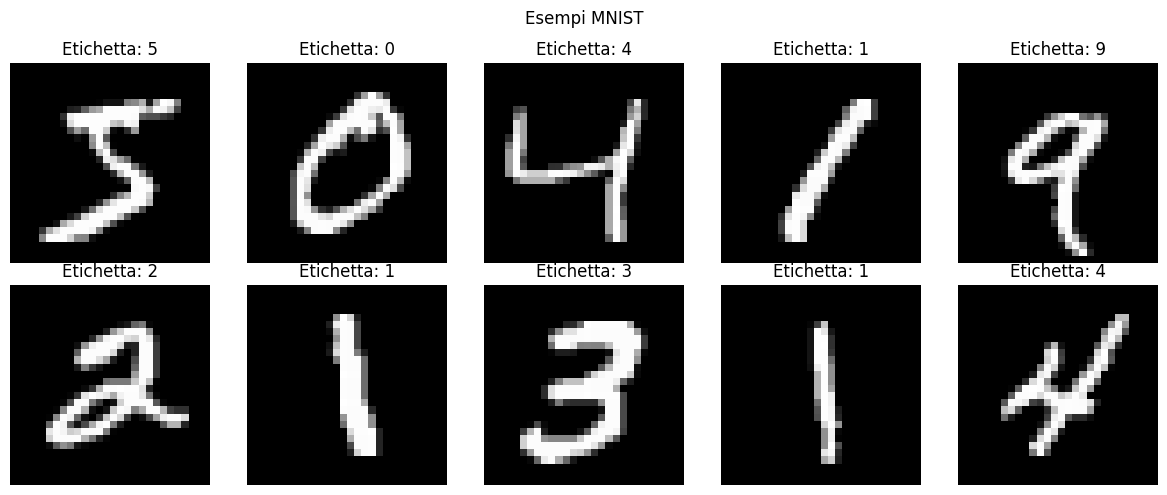

In [2]:
# Caricamento MNIST da torchvision
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

X_train = mnist_train.data.numpy()  # (60000, 28, 28)
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nRange valori pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {np.unique(y_train)}")

# Visualizzazione esempi
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Etichetta: {y_train[i]}")
    ax.axis('off')
plt.suptitle('Esempi MNIST')
plt.tight_layout()
plt.show()

In [3]:
# Flatten: da (28, 28) a (784,)
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

print(f"Shape dopo flatten:")
print(f"  Training: {X_train_flat.shape}")
print(f"  Test: {X_test_flat.shape}")

# Normalizzazione
X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

print(f"\nRange dopo normalizzazione: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Shape dopo flatten:
  Training: (60000, 784)
  Test: (10000, 784)

Range dopo normalizzazione: [0.00, 1.00]


### 4.3 Costruzione del Modello

PyTorch offre due approcci principali per costruire modelli:
1. **`nn.Sequential`**: per modelli lineari (layer dopo layer)
2. **`nn.Module` subclassing**: per architetture complesse con forward() personalizzato

Useremo `nn.Sequential`.

In [5]:
# Creazione modello
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

# Visualizzazione architettura
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

Total params: 109,386
Trainable params: 109,386


**Spiegazione dell'architettura:**

1. **Hidden Layer 1**: 784 input → 128 neuroni con ReLU
   - Parametri: (784 × 128) + 128 bias = 100,480

2. **Hidden Layer 2**: 128 input → 64 neuroni con ReLU
   - Parametri: (128 × 64) + 64 bias = 8,256

3. **Output Layer**: 64 input → 10 neuroni (logits)
   - Parametri: (64 × 10) + 10 bias = 650
   - **Nota**: Non serve un layer Softmax esplicito perche' `nn.CrossEntropyLoss` applica internamente `log_softmax` + `NLLLoss`

**Totale parametri trainabili: 109,386**

### 4.4 Compilazione del Modello

Prima del training, dobbiamo specificare:
1. **Optimizer**: algoritmo di ottimizzazione (Adam e' lo standard)
2. **Loss function**: funzione da minimizzare
3. **Metriche**: per monitorare il training

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Modello compilato e pronto per il training")

Modello compilato e pronto per il training


**Note sulle loss functions in PyTorch:**

- **`nn.CrossEntropyLoss`**: per classificazione multi-classe con label intere (0, 1, 2, ..., 9). Combina `log_softmax` + `NLLLoss` internamente
- **`nn.CrossEntropyLoss`** (con one-hot): se le label sono one-hot encoded, convertire prima in indici con `argmax`
- **`nn.BCEWithLogitsLoss`**: per classificazione binaria (applica sigmoid internamente)

### 4.5 Training del Modello

In [7]:
# Training
# Preparazione dati
X_train_tensor = torch.FloatTensor(X_train_norm).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)

# Split training/validation (80/20)
n_val = int(len(X_train_tensor) * 0.2)
indices = torch.randperm(len(X_train_tensor))
train_indices = indices[n_val:]
val_indices = indices[:n_val]

X_tr = X_train_tensor[train_indices]
y_tr = y_train_tensor[train_indices]
X_val = X_train_tensor[val_indices]
y_val = y_train_tensor[val_indices]

train_dataset = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training loop with pretrained weight support
def _train_basic_mlp():
    epochs = 10
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_acc = (val_predicted == y_val).sum().item() / len(y_val)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

    return history

history = load_or_train(model, _train_basic_mlp, 'nb04_basic_mlp.pt', device=device)
print("\nTraining completato")

Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb04_basic_mlp.pt

Training completato


**Parametri di training:**

- **epochs**: numero di passaggi completi sul dataset
- **batch_size**: numero di sample processati prima di aggiornare i pesi
  - Batch piccoli: piu' rumore, ma converge piu' velocemente
  - Batch grandi: gradienti piu' stabili, ma serve piu' memoria
- **validation split**: in PyTorch si divide manualmente il dataset in training e validation (es. 80/20) prima del training loop

### 4.6 Visualizzazione Training History

In [8]:
# Plot learning curves
if history is None:
    print("Using pretrained weights - training curves not available")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss durante Training')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy
    axes[1].plot(history['accuracy'], label='Training Accuracy')
    axes[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy durante Training')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

Using pretrained weights - training curves not available


### 4.7 Valutazione sul Test Set

Test Loss: 0.0839
Test Accuracy: 0.9738

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.97      0.95      0.96       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



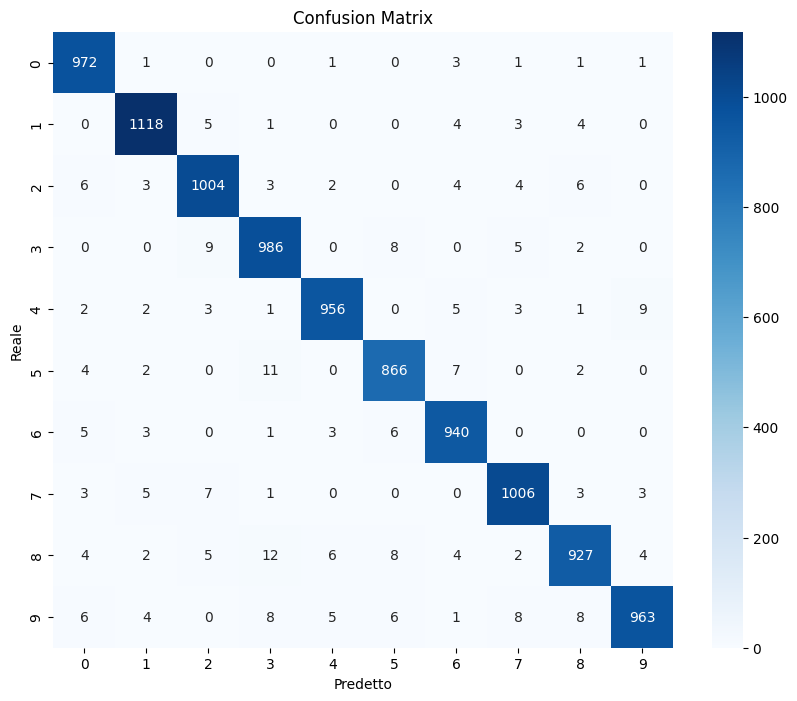

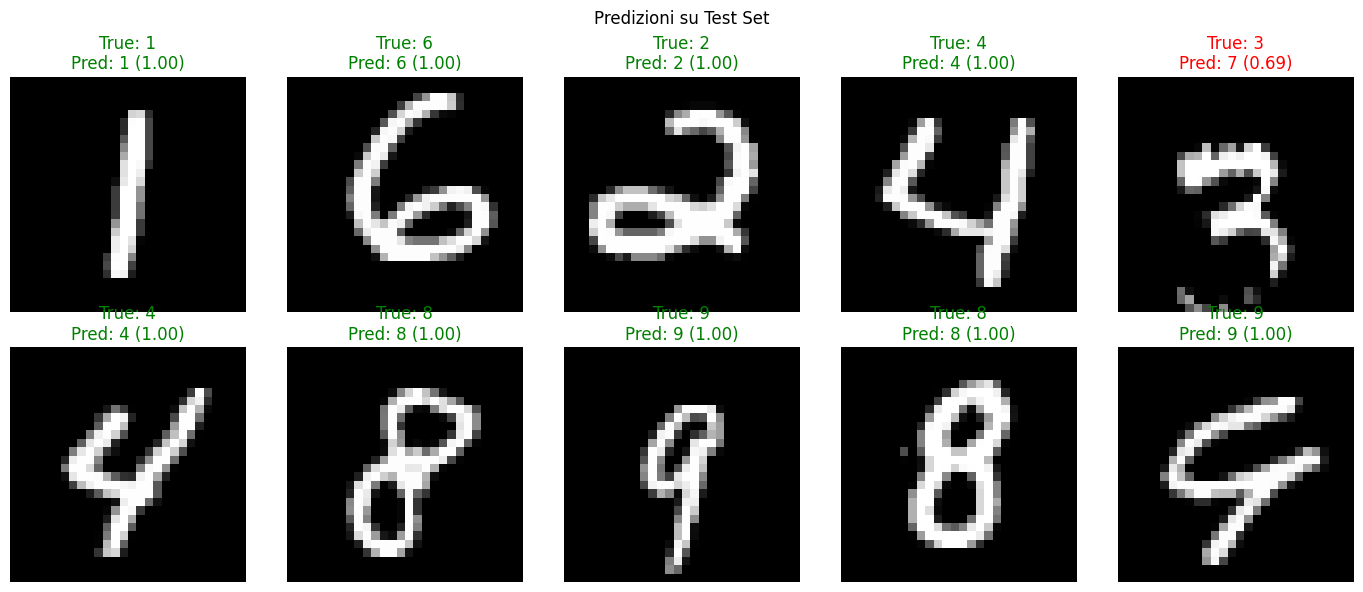

In [9]:
# Valutazione
X_test_tensor = torch.FloatTensor(X_test_norm).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor).item()
    _, y_pred_tensor = torch.max(test_outputs, 1)
    test_accuracy = (y_pred_tensor == y_test_tensor).sum().item() / len(y_test_tensor)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predizioni
y_pred = y_pred_tensor.cpu().numpy()
y_pred_proba = torch.softmax(test_outputs, dim=1).cpu().numpy()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix')
plt.show()

# Visualizzazione predizioni
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test))
    ax.imshow(X_test[idx], cmap='gray')

    true_label = y_test[idx]
    pred_label = y_pred[idx]
    confidence = y_pred_proba[idx][pred_label]

    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", color=color)
    ax.axis('off')

plt.suptitle('Predizioni su Test Set')
plt.tight_layout()
plt.show()